# Tutorial
The basic steps of ikarus are similar to the [sklearn workflow](https://scikit-learn.org/stable/getting_started.html#fitting-and-predicting-estimator-basics):

0. load data sets
1. init model
2. fit model
3. predict

In [1]:
import anndata
import pandas as pd
from pathlib import Path
from ikarus import classifier, utils

## load data sets
Laughney lung cancer and Lee colorectal cancer are used for training.<br>
Tirosh head & neck cancer is used for testing.<br>
Annotated data matrices are used here (see [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) for further information.)


In [2]:
paths = [
    Path("data/laughney20_lung/"),
    Path("data/lee20_crc/"),
    Path("data/tirosh17_headneck/")
]
names = [
    "laughney",
    "lee",
    "tirosh"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

In [3]:
adatas["lee"].obs.head(2)

,raw,major,major_hallmark_corrected,tier_0,tier_1,tier_2,tier_3,tier_4,tier_5,tier_0_hallmark_corrected
0,CMS2,Tumor,Tumor,Tumor,Epithelial,nan,nan,nan,nan,Tumor
1,CMS2,Tumor,Tumor,Tumor,Epithelial,nan,nan,nan,nan,Tumor


In [4]:
adatas["lee"].var.head(2)

,gene_symbol
A1BG,A1BG
A1BG-AS1,A1BG-AS1


In [5]:
adatas["lee"].to_df().head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.233330,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.465363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.259511,0.908856,0.259511,0.0,0.0,0.0,0.0,0.0


## signatures
Here we just define the path of our gene signatures of choice.<br>
(find more information on how the gene lists are created [below](#create-gene-lists))

Note: It is important that the name (see first column in the example) of the gene lists<br>
within the `signatures.gmt` file correspond to the cell type for which they are meaningful.<br>
`signatures.gmt` is tab-separated.

In [19]:
signatures_path = Path("out_tutorial/signatures.gmt")

In [20]:
pd.read_csv(signatures_path, sep="\t", header=None)

,0,1,2,3,4,5,6,7,8,9,...,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314
0,Normal,ikarus,ATP10B,RP11-367G6.3,CFAP52,HMCN1,APOH,EPN3,MUC5AC,ANKRD66,...,CCDC80,MUC3A,SDCBP2,TNFSF8,CFAP206,LTBP2,LHFP,LCK,SRGN,TRPC4
1,Tumor,ikarus,RP11-277P12.10,RP13-895J2.6,BNC1,MAGEA6,ISX,MAGEA3,RP13-614K11.2,CDH7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## train model
Unlike the X and y input from the sklearn fitting, we are using here the AnnData object<br>
loaded above and the corresponding observation column (annotation). The input AnnData<br>
objects, names and target observation columns are each provided as lists. As one may want<br>
to use multiple input data sets.

(Note: Here this may take a while, as the used input data sets are quite large.<br>
Skip this cell in case you just want load the pretrained model.)

In [21]:
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out_tutorial")

train_adata_list = [adatas["laughney"], adatas["lee"]]
train_names_list = ["laughney", "lee"]
obs_columns_list = ["tier_0_hallmark_corrected", "tier_0_hallmark_corrected"]

model.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

Alternatively just load the pretrained model.

In [8]:
model_path = Path("out_tutorial/core_model.joblib")
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out_tutorial")
model.load_core_model(model_path)

## make prediction
We provide the AnnData of an unknown data set, make predictions and save the results.

In [9]:
_ = model.predict(adatas['tirosh'], 'tirosh', save=True)

/home/jdohmen/.miniconda3/envs/ikarus/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 9 with 0.0004 < 0.001


Your predictions `prediction.csv` are saved to your output directory as specified in the model<br> initialization. At this point you might try to [correct the predictions by making use of CNV information](make-use-of-cnv-information-and-correct-prediction).<br>
Else, go on with the plotting part to verify the results.

## plotting
Make plots to investigate the prediction results.

In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax

Compute UMAPs and store the adata object `adata_umap.h5ad`.

In [11]:
_ = model.get_umap(adatas['tirosh'], 'tirosh', save=True)

... storing 'core_pred' as categorical
... storing 'final_pred' as categorical


Load prediction results and the AnnData object including the just computed UMAP coordinates.

In [12]:
path = Path("out_tutorial/tirosh")
results = pd.read_csv(path / "prediction.csv", index_col=0)
adata = anndata.read_h5ad(path / "adata_umap.h5ad")

Print classification metrics and show confusion matrix and UMAPs.

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3363
       Tumor       1.00      1.00      1.00      2215

    accuracy                           1.00      5578
   macro avg       1.00      1.00      1.00      5578
weighted avg       1.00      1.00      1.00      5578



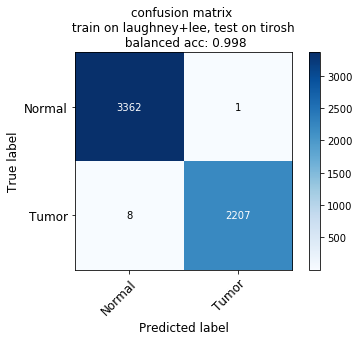

In [13]:
y = adata.obs.loc[:, 'tier_0']
y_pred_lr = results['final_pred']
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=['Normal', 'Tumor']))
_ = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=['Normal', 'Tumor'],
    title=f'confusion matrix \n train on laughney+lee, test on tirosh \n balanced acc: {acc:.3f}',
)

... storing 'tier_0_pred_correctness' as categorical


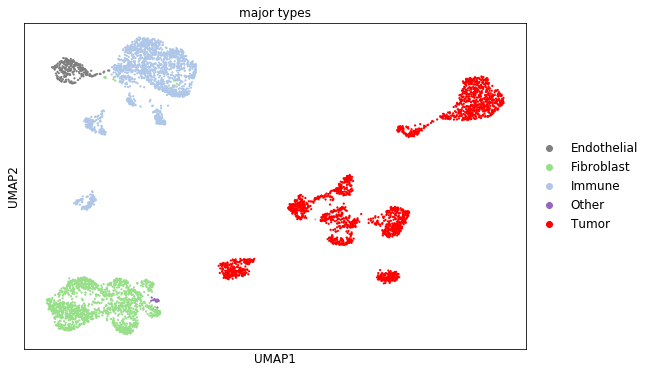

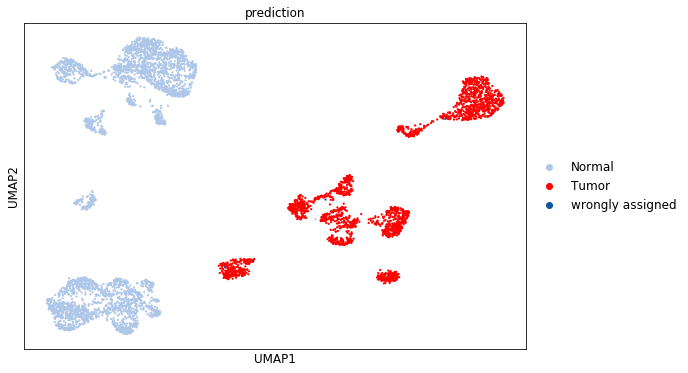

In [14]:
adata.obs.loc[:, 'tier_0_pred_correctness'] = 'wrongly assigned'
adata.obs.loc[
    adata.obs['tier_0'] == adata.obs['final_pred'],
    'tier_0_pred_correctness'
] = 'correctly assigned'
adata.obs.loc[:, 'tier_0_pred_wrong'] = pd.Categorical(
    adata.obs['tier_0'].copy(),
    categories=np.array(['Normal', 'Tumor', 'wrongly assigned']),
    ordered=True
)
adata.obs.loc[
    adata.obs['tier_0_pred_correctness'] == 'wrongly assigned',
    'tier_0_pred_wrong'
] = 'wrongly assigned'

plt.rcParams['figure.figsize'] = [9, 6]

colors = [
    ['major'],
    ['tier_0_pred_wrong']
    ]
titles = [
    ['major types'],
    ['prediction']
    ]
palettes = [
    ['#7f7f7f', '#98df8a', '#aec7e8', '#9467bd', '#ff0000'],
    ['#aec7e8', '#ff0000', '#0b559f'], 
]
for color, title, palette in zip(colors, titles, palettes):
    ax = sc.pl.umap(
        adata, ncols=1, size=20, 
        color=color,
        title=title,
        wspace=0.25,
        vmax='p99',
        legend_fontsize=12,
        palette=palette,
        show=False
    )
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.show()

## extra

### create gene lists

In [6]:
import upsetplot
import anndata
import pandas as pd
from pathlib import Path
from ikarus import gene_list, utils

#### tumor

First, we define the input datasets used to create the gene lists,<br>
the upregulated and downregulated cell types. Here, we consider<br>
six different pair-wise comparisons:
- Tumor vs. Other
- Tumor vs. Epithelial
- Tumor vs. Immune
- Tumor vs. Fibroblast
- Tumor vs. Endothelial
- Tumor vs. Pericyte

In [7]:
paths = [
    Path("data/laughney20_lung/"),
    Path("data/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
obs_names = [
    "major_hallmark_corrected",
    "major_hallmark_corrected"
]
label_upregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_downregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

We loop over all pair-wise comparisons and over both input datasets,<br>
and perform t-tests with overestimated variance so that we obtain<br>
for each gene two (one for each dataset) estimates of log2fold changes.<br>
For integrating the outcome of both datasets, first of all we just consider<br>
genes available in both datasets (intersection). Then we compute for each gene<br>
the weighted average of log2fold changes. For each pair-wise comparison we take<br>
the top 300 of upregulated (highest averaged log2fold changes) genes.

In [8]:
signatures = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

Either Tumor or Fibroblast is not available in given obs_name. None is returned.
Either Tumor or Endothelial is not available in given obs_name. None is returned.
Either Tumor or Pericyte is not available in given obs_name. None is returned.


Here we use UpSetPlots to visualize the amount of genes overlapping across<br>
multiple pair-wise comparisons.

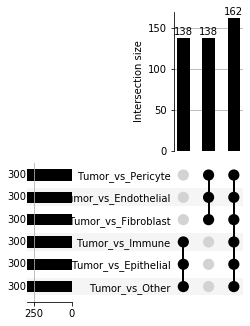

In [9]:
contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')

Get the intersection of all the different gene lists.<br>
This leads to our final tumor gene list of 162 genes.

In [10]:
tumor_genes_intersection = contents.loc[
    (True, True, True, True, True, True)
].values.ravel().tolist()

<ipython-input-10-82e046d08432>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tumor_genes_intersection = contents.loc[


In [11]:
tumor_genes = tumor_genes_intersection

Later, when creating the normal gene list, we will remove<br>
those genes, which were also upregulated in the pair-wise<br>
comparisons from above (Tumor vs. X). For that purpose, we<br>
create here the union of the tumor genes coming from all<br>
pair-wise comparisons. This is not used as our final Tumor gene<br>
list. It's just used to refine the Normal gene list.

In [12]:
tumor_genes_union = []
for i in signatures.values():
    tumor_genes_union += i
tumor_genes_union = list(set(tumor_genes_union)) # unique genes

#### normal
Basically repeat the above procedure for the normal gene list.<br>
Though, here we take the union of genes upregulated in non-tumor cells. 

First, we define the input datasets used to create the gene lists,<br>
the upregulated and downregulated cell types. Here, we consider<br>
six different pair-wise comparisons:
- Other vs. Tumor
- Epithelial vs. Tumor
- Immune vs. Tumor
- Fibroblast vs. Tumor
- Endothelial vs. Tumor
- Pericyte vs. Tumor

In [13]:
paths = [
    Path("data/laughney20_lung/"),
    Path("data/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
obs_names = [
    "major_hallmark_corrected",
    "major_hallmark_corrected"
]
label_downregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_upregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

We loop over all pair-wise comparisons and over both input datasets,<br>
and perform t-tests with overestimated variance so that we obtain<br>
for each gene two (one for each dataset) estimates of log2fold changes.<br>
For integrating the outcome of both datasets, first of all we just consider<br>
genes available in both datasets (intersection). Then we compute for each gene<br>
the weighted average of log2fold changes. For each pair-wise comparison we take<br>
the top 300 of upregulated (highest averaged log2fold changes) genes.

In [14]:
signatures = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

Either Fibroblast or Tumor is not available in given obs_name. None is returned.
Either Endothelial or Tumor is not available in given obs_name. None is returned.
Either Pericyte or Tumor is not available in given obs_name. None is returned.


Again. here we use UpSetPlots to visualize the amount of genes overlapping<br>
across multiple pair-wise comparisons.

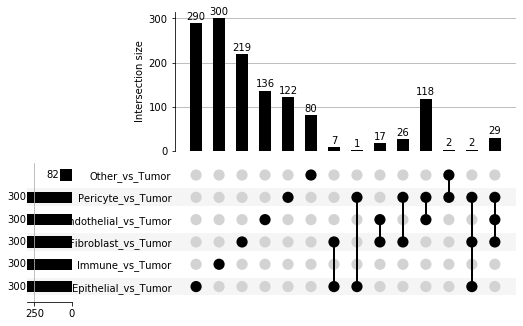

In [15]:
contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')

Get unique genes from the six pairwise comparisons.

In [16]:
normal_genes_union = []
for i in signatures.values():
    normal_genes_union += i
normal_genes_union = list(set(normal_genes_union)) # unique genes

Remove genes which are overlapping with the union of tumor genes<br>
from all pair-wise comparisons with Tumor being the upregulated<br>
class (see above).

In [17]:
overlap = list(set(tumor_genes_union) & set(normal_genes_union))
normal_genes = list(set(normal_genes_union) - set(overlap))

Save signatures as `.gmt` file.

In [18]:
gene_list.save_gmt([normal_genes, tumor_genes], ["Normal", "Tumor"], out_dir="out_tutorial")

### make use of cnv information and correct prediction
Altough, for this particular test data set this step might seem unnecessary,<br>
incorporating cnv information might help to improve prediction results.

[inferCNV, v1.3.3](https://github.com/broadinstitute/inferCNV) was used to compute CNV scores.

In [15]:
cnv_path = Path("data/tirosh/infercnv.observations.txt")
cnv = pd.read_csv(cnv_path, sep=' ')
cnv.columns = cnv.columns.astype('int')
cnv.sort_index(axis=1, inplace=True)
cnv = cnv.T

In [16]:
cnv.head(2)

,WASH7P,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TNFRSF18,...,SBF1,LMF2,NCAPH2,SCO2,TYMP,ODF3B,CPT1B,CHKB,ARSA,RABL2B
0,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,...,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759
1,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,1.002759,...,0.850724,0.850990,0.851188,0.850058,0.849016,0.848378,0.847733,0.847032,0.846197,0.845542


In [18]:
_ = model.cnv_correct(cnv, adatas['tirosh'], save=True, name="tirosh")

/home/jdohmen/.miniconda3/envs/ikarus/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jdohmen/.miniconda3/envs/ikarus/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 4 with 0.0002 < 0.001


Verify CNV corrected results.

In [19]:
path = Path("out_tutorial/tirosh")
results = pd.read_csv(path / "prediction.csv", index_col=0)
adata = anndata.read_h5ad(path / "adata_umap.h5ad")

In [20]:
results.head(2)

,Normal,Tumor,core_pred,core_pred_proba_Normal,core_pred_proba_Tumor,final_pred,final_pred_proba_Normal,final_pred_proba_Tumor,final_pred_cnv_corrected
0,0.594337,0.022227,Normal,0.860578,0.139422,Normal,0.855554,0.144446,Normal
1,0.497349,0.018539,Normal,0.869987,0.130013,Normal,0.844260,0.155740,Normal


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3363
       Tumor       1.00      1.00      1.00      2215

    accuracy                           1.00      5578
   macro avg       1.00      1.00      1.00      5578
weighted avg       1.00      1.00      1.00      5578



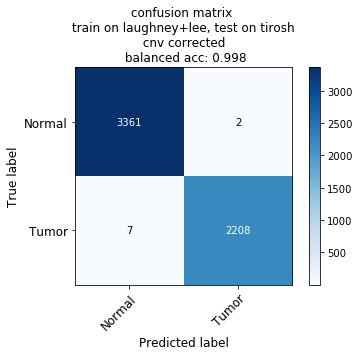

In [22]:
y = adata.obs.loc[:, 'tier_0']
y_pred_lr = results['final_pred_cnv_corrected']
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=['Normal', 'Tumor']))
_ = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=['Normal', 'Tumor'],
    title=f'confusion matrix \n train on laughney+lee, test on tirosh \n cnv corrected \n balanced acc: {acc:.3f}',
)